In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, GlobalAveragePooling1D, Reshape, multiply, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats.mstats import winsorize

In [2]:
data = pd.read_csv('Raw Dataset/train_data.csv')

print(f"Jumlah data sebelum: {len(data)}")

print(data.duplicated().sum())
print(data.describe())
# Menghapus data duplikat
data = data.drop_duplicates()

# Melihat jumlah data setelah duplikat dihapus
print(f"Jumlah data setelah: {len(data)}")

Jumlah data sebelum: 179647
168517
       Unnamed: 0.1    Unnamed: 0         MMSI            LAT            LON  \
count  1.796470e+05  1.796470e+05     179647.0  179647.000000  179647.000000   
mean   2.311784e+07  3.772399e+06  247320400.0      33.841062     -76.574828   
std    1.443749e+07  1.958749e+06          0.0       6.213861       3.541134   
min    1.319408e+06  1.610000e+02  247320400.0      22.551680     -97.323980   
25%    9.352686e+06  2.329360e+06  247320400.0      26.481370     -80.038420   
50%    1.710573e+07  3.829157e+06  247320400.0      35.190460     -75.257310   
75%    3.671972e+07  5.316564e+06  247320400.0      40.259680     -73.853180   
max    6.154855e+07  7.677052e+06  247320400.0      41.612140     -71.347070   

                 SOG            COG        Heading  VesselType         Status  \
count  179647.000000  179647.000000  179647.000000    179647.0  179647.000000   
mean       17.565579     130.927354     139.068562        70.0       0.022978   
s

In [3]:
# Load data
data = pd.read_csv('Raw Dataset/train_data.csv')

print(data.isna().any().any())

data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])
data.sort_values('BaseDateTime', inplace=True)

print(data.head())


False
       Unnamed: 0.1  Unnamed: 0       MMSI        BaseDateTime       LAT  \
0           1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
3422        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
5019        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
7525        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
10762       1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   

            LON   SOG   COG  Heading      VesselName         IMO CallSign  \
0     -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
3422  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
5019  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
7525  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
10762 -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   

       VesselType  Status  Length  Width  Draft  Cargo TransceiverClass  


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179647 entries, 0 to 179642
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0.1      179647 non-null  int64         
 1   Unnamed: 0        179647 non-null  int64         
 2   MMSI              179647 non-null  int64         
 3   BaseDateTime      179647 non-null  datetime64[ns]
 4   LAT               179647 non-null  float64       
 5   LON               179647 non-null  float64       
 6   SOG               179647 non-null  float64       
 7   COG               179647 non-null  float64       
 8   Heading           179647 non-null  float64       
 9   VesselName        179647 non-null  object        
 10  IMO               179647 non-null  object        
 11  CallSign          179647 non-null  object        
 12  VesselType        179647 non-null  float64       
 13  Status            179647 non-null  float64       
 14  Length   

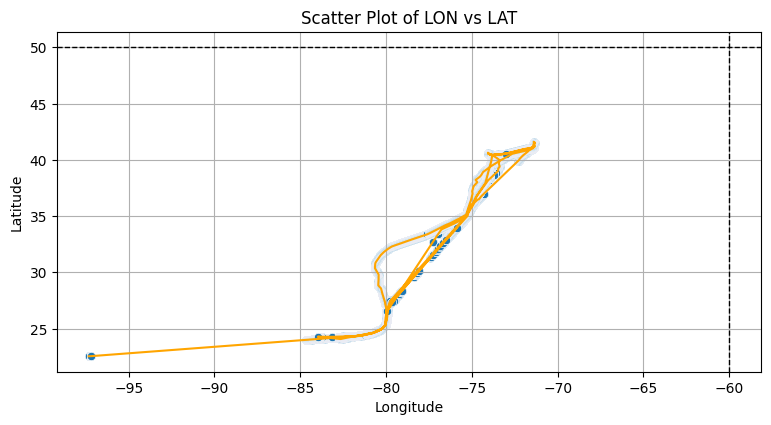

In [5]:
# Create the figure and subplot
plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 3)

# Plot the scatter points
sns.scatterplot(x='LON', y='LAT', data=data)
plt.title('Scatter Plot of LON vs LAT')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add lines connecting the points
plt.plot(data['LON'], data['LAT'], linestyle='-', color='orange')  # Draw straight lines between points

# Add Cartesian grid lines
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0 (x-axis)
plt.axvline(x=-60, color='black', linestyle='--', linewidth=1)  # Vertical line at x=0 (y-axis)
plt.grid(True)  # Enable the grid

# Show the plot
plt.show()

In [6]:
data['LAT'] = winsorize(data['LAT'], limits=[0.01, 0.01])  # Potong 1% nilai ekstrem
data['LON'] = winsorize(data['LON'], limits=[0.01, 0.01])

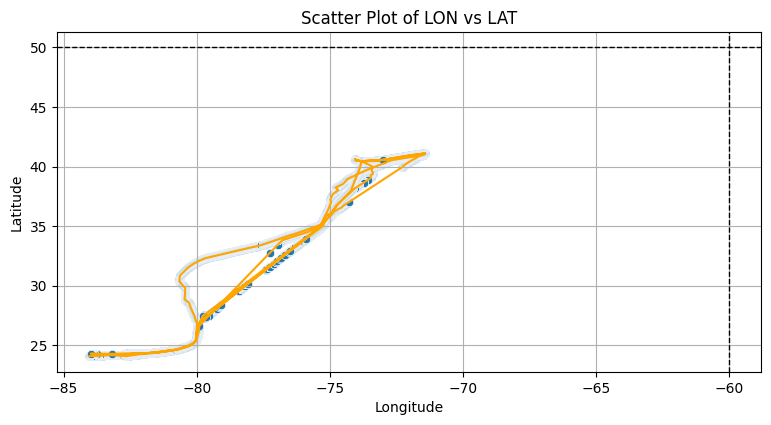

In [7]:
# Create the figure and subplot
plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 3)

# Plot the scatter points
sns.scatterplot(x='LON', y='LAT', data=data)
plt.title('Scatter Plot of LON vs LAT')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add lines connecting the points
plt.plot(data['LON'], data['LAT'], linestyle='-', color='orange')  # Draw straight lines between points

# Add Cartesian grid lines
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0 (x-axis)
plt.axvline(x=-60, color='black', linestyle='--', linewidth=1)  # Vertical line at x=0 (y-axis)
plt.grid(True)  # Enable the grid

# Show the plot
plt.show()

In [8]:
# Feature scaling
scalers = {col: MinMaxScaler() for col in ['LAT', 'LON', 'SOG', 'COG']}
for col, scaler in scalers.items():
    data[[col]] = scaler.fit_transform(data[[col]])
    

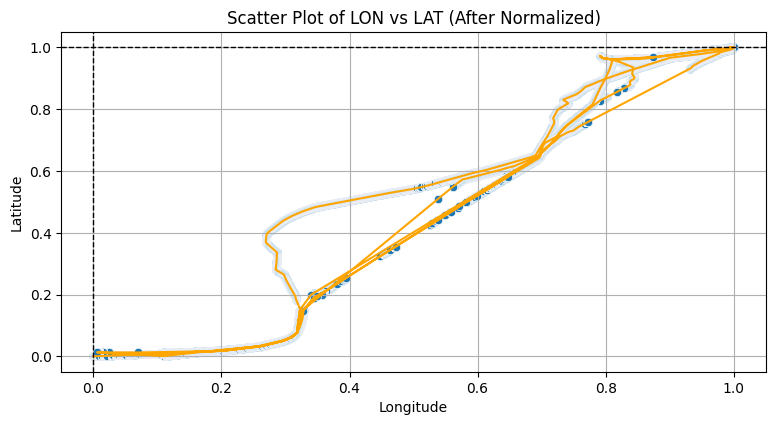

In [9]:
# Create the figure and subplot
plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 3)

# Plot the scatter points
sns.scatterplot(x='LON', y='LAT', data=data)
plt.title('Scatter Plot of LON vs LAT (After Normalized)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add lines connecting the points
plt.plot(data['LON'], data['LAT'], linestyle='-', color='orange')  # Draw straight lines between points

# Add Cartesian grid lines
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0 (x-axis)
plt.axvline(x=-0, color='black', linestyle='--', linewidth=1)  # Vertical line at x=0 (y-axis)
plt.grid(True)  # Enable the grid

# Show the plot
plt.show()

In [10]:
# Create sequences for training
SEQ_LENGTH = 10

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length]
        label = data.iloc[i+seq_length]
        sequences.append((seq[['LAT', 'LON', 'SOG', 'COG']].values, label[['LAT', 'LON']].values))
    return sequences

sequences = create_sequences(data, SEQ_LENGTH)

# Split data into features and labels
X, y = zip(*sequences)
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

# Ensure Correct Data Types
X = X.astype(np.float32)
y = y.astype(np.float32)

split_index = int(0.8 * len(X))  # 80% untuk training, 20% untuk testing
X_train_full, X_test = X[:split_index], X[split_index:]
y_train_full, y_test = y[:split_index], y[split_index:]



In [11]:
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x


def build_model(seq_length, embedding_dim):
    input_seq = Input(shape=(seq_length, 4), name='input_seq')

    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_seq)
    x = squeeze_excite_block(x)
    x = GlobalAveragePooling1D()(x)

    # LSTM layers
    lstm_out = LSTM(64)(Lambda(lambda x: tf.expand_dims(x, axis=1))(x))  # Wrap tf.expand_dims

    # Fully connected layers
    output = Dense(2)(lstm_out)

    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


In [12]:
from sklearn.metrics import mean_squared_error

def armse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def amape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-10, None))) * 100




In [13]:
# Initialize Time Series Split Cross-Validation
tscv = TimeSeriesSplit(n_splits=10)

# Cross-validation loop on the training set (X_train_full, y_train_full)
fold_no = 1


In [14]:
# List untuk menyimpan hasil evaluasi per fold
armse_scores = []
amape_scores = []

fold_no = 1  # Inisialisasi nomor fold

for train_index, val_index in tscv.split(X_train_full):
    print(f"Training fold {fold_no}...")

    # Split data into training dan validation untuk fold ini
    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Bangun model
    model = build_model(SEQ_LENGTH, 4)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train model
    history = model.fit(
        X_train, y_train, epochs=200, batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )

    # Prediksi pada validation set
    y_val_pred = model.predict(X_val)

    # Inverse transform hasil prediksi dan ground truth
    y_val[:, 0] = scalers['LAT'].inverse_transform(y_val[:, 0].reshape(-1, 1)).reshape(-1)
    y_val[:, 1] = scalers['LON'].inverse_transform(y_val[:, 1].reshape(-1, 1)).reshape(-1)
    y_val_pred[:, 0] = scalers['LAT'].inverse_transform(y_val_pred[:, 0].reshape(-1, 1)).reshape(-1)
    y_val_pred[:, 1] = scalers['LON'].inverse_transform(y_val_pred[:, 1].reshape(-1, 1)).reshape(-1)

    # Hitung metrik evaluasi
    armse_score = armse(y_val, y_val_pred)
    amape_score = amape(y_val, y_val_pred)

    # Simpan skor ke dalam list
    armse_scores.append(armse_score)
    amape_scores.append(amape_score)

    print(f"Fold {fold_no} - ARMSE: {armse_score}, AMAPE: {amape_score}")

    fold_no += 1  # Update nomor fold

# Hitung rata-rata ARMSE dan AMAPE dari seluruh fold
avg_armse = sum(armse_scores) / len(armse_scores)
avg_amape = sum(amape_scores) / len(amape_scores)

print(f"\nAverage ARMSE: {avg_armse}")
print(f"Average AMAPE: {avg_amape}")

# Evaluasi pada test set
print("Evaluating on test set...")
y_test_pred = model.predict(X_test)


Training fold 1...

Epoch 1/200
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0033 - mae: 0.0312 - val_loss: 0.0564 - val_mae: 0.1643 - learning_rate: 0.0010
Epoch 2/200
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5044e-06 - mae: 0.0018 - val_loss: 0.0424 - val_mae: 0.1300 - learning_rate: 0.0010
Epoch 3/200
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9910e-06 - mae: 0.0011 - val_loss: 0.0361 - val_mae: 0.1182 - learning_rate: 0.0010
Epoch 4/200
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9203e-06 - mae: 8.9464e-04 - val_loss: 0.0310 - val_mae: 0.1105 - learning_rate: 0.0010
Epoch 5/200
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5370e-06 - mae: 7.4991e-04 - val_loss: 0.0253 - val_mae: 0.1010 - learning_rate: 0.0010
Epoch 6/200
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2802e-06 - mae: 6.6952e-04 - val_loss: 0.0211 - val_mae: 0.0939 - learning_rate: 0.0010
Epoch 7/200
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0887e-06 - mae: 5.9854e-04 

In [15]:
print(armse_scores)
print(amape_scores)
print(sum(armse_scores)/len(armse_scores))
print(sum(amape_scores)/len(amape_scores))

[0.41019925, 0.23960373, 0.16508618, 0.3819328, 0.049233343, 0.08026928, 0.11620799, 0.038034033, 0.034610778, 0.0038709142]
[0.7628823164850473, 0.3893428947776556, 0.28454666025936604, 0.6339266896247864, 0.07050078129395843, 0.0951473310124129, 0.14156197430565953, 0.08665398927405477, 0.0678414711728692, 0.0057321700296597555]
0.15190482907928526
0.253813627823547


In [16]:
# Inverse transform predictions and actual values for the test set
y_test[:, 0] = scalers['LAT'].inverse_transform(y_test[:, 0].reshape(-1, 1)).reshape(-1)
y_test[:, 1] = scalers['LON'].inverse_transform(y_test[:, 1].reshape(-1, 1)).reshape(-1)
y_test_pred[:, 0] = scalers['LAT'].inverse_transform(y_test_pred[:, 0].reshape(-1, 1)).reshape(-1)
y_test_pred[:, 1] = scalers['LON'].inverse_transform(y_test_pred[:, 1].reshape(-1, 1)).reshape(-1)

# Evaluasi pada test set
armse_test = armse(y_test, y_test_pred)
amape_test = amape(y_test, y_test_pred)

print(f"Test Set ARMSE: {armse_test}, Test Set AMAPE: {amape_test}")


Test Set ARMSE: 0.06509887427091599, Test Set AMAPE: 0.014850105799268931


In [24]:
print(f"Test Set ARMSE: {armse_test}")
print(f"Test Set AMAPE: {amape_test}")

Test Set ARMSE: 0.06509887427091599
Test Set AMAPE: 0.014850105799268931


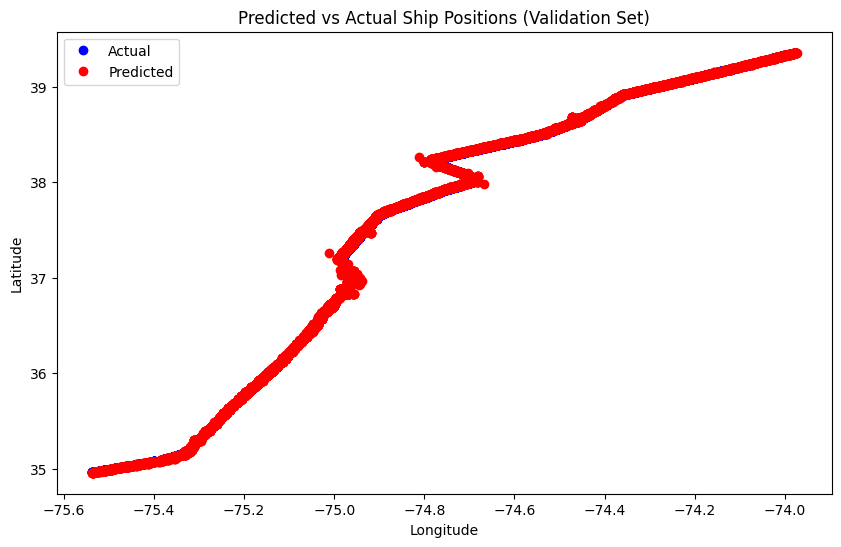

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(y_val[:, 1], y_val[:, 0], 'bo', label='Actual')  # Longitude di sumbu x, Latitude di sumbu y
plt.plot(y_val_pred[:, 1], y_val_pred[:, 0], 'ro', label='Predicted')  # Prediksi Longitude & Latitude
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.legend()
plt.title('Predicted vs Actual Ship Positions (Validation Set)')
plt.show()


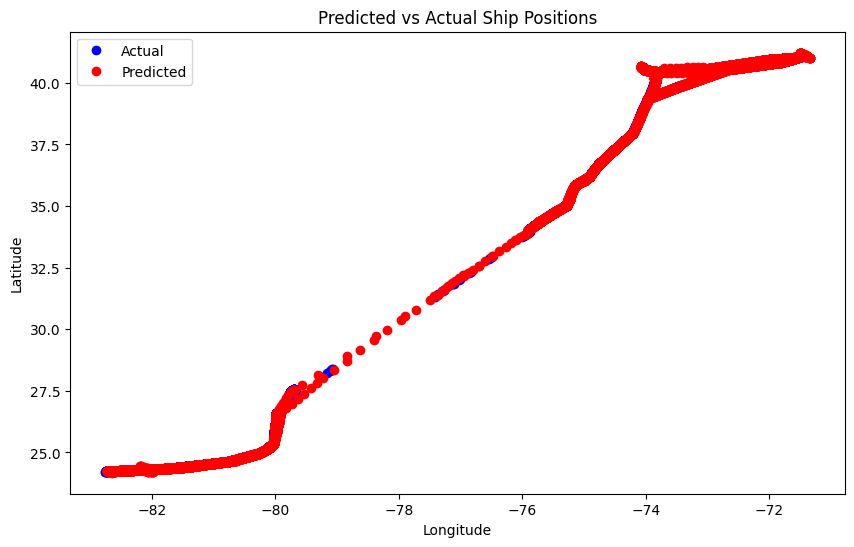

In [17]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 1], y_test[:, 0], 'bo', label='Actual')   # y_test[:, 1] untuk Longitude, y_test[:, 0] untuk Latitude
plt.plot(y_test_pred[:, 1], y_test_pred[:, 0], 'ro', label='Predicted') # y_pred[:, 1] untuk Longitude, y_pred[:, 0] untuk Latitude
plt.xlabel('Longitude')  # Label untuk sumbu x
plt.ylabel('Latitude')   # Label untuk sumbu y
plt.legend()
plt.title('Predicted vs Actual Ship Positions')
plt.show()


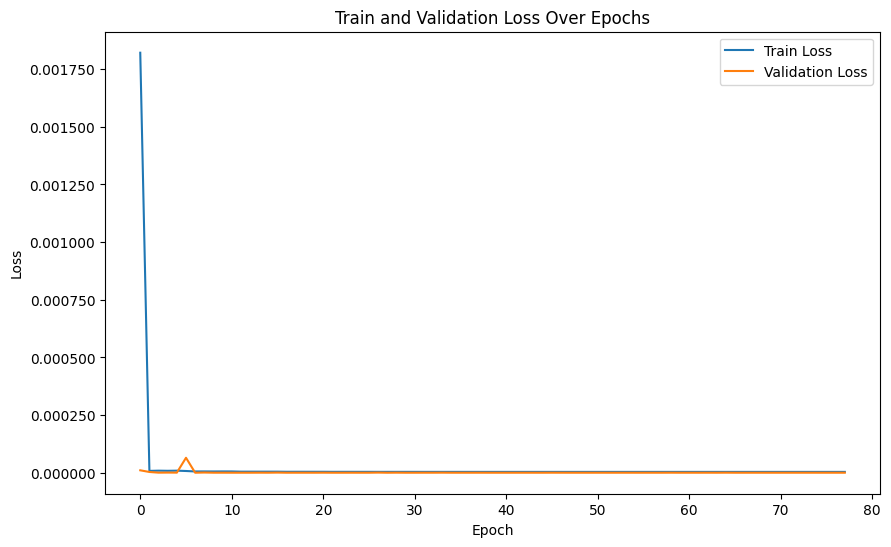

In [18]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()


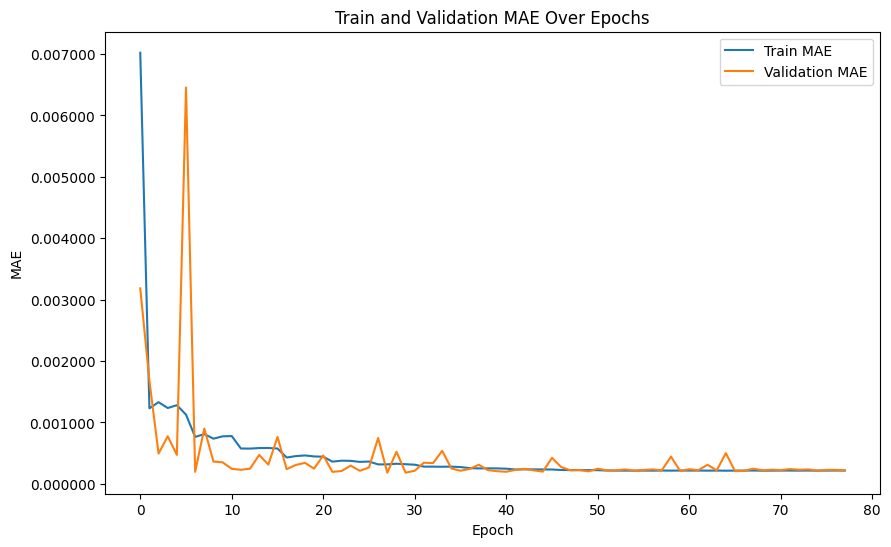

In [19]:
# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Train and Validation MAE Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()

In [20]:
def predict_next_position(lat_manual, lon_manual, sog_manual, cog_manual, model, scalers, seq_length=10):
    """
    Memprediksi latitude dan longitude berikutnya berdasarkan input manual dan model yang dilatih.

    Args:
    lat_manual: Latitude yang diinput secara manual.
    lon_manual: Longitude yang diinput secara manual.
    sog_manual: Speed Over Ground (SOG) yang diinput secara manual.
    cog_manual: Course Over Ground (COG) yang diinput secara manual.
    model: Model CNN-LSTM yang sudah dilatih.
    scalers: Dictionary yang berisi scaler untuk setiap fitur (LAT, LON, SOG, COG).
    seq_length: Panjang sequence yang dibutuhkan model, default 10.

    Returns:
    Prediksi latitude dan longitude berikutnya.
    """
    # Buat input array berdasarkan input manual
    input_data = np.array([[lat_manual, lon_manual, sog_manual, cog_manual]])

    # Lakukan scaling sesuai skema sebelumnya
    input_data[:, 0] = scalers['LAT'].transform(input_data[:, 0].reshape(-1, 1)).reshape(-1)
    input_data[:, 1] = scalers['LON'].transform(input_data[:, 1].reshape(-1, 1)).reshape(-1)
    input_data[:, 2] = scalers['SOG'].transform(input_data[:, 2].reshape(-1, 1)).reshape(-1)
    input_data[:, 3] = scalers['COG'].transform(input_data[:, 3].reshape(-1, 1)).reshape(-1)

    # Buat sequence dengan panjang seq_length dengan menduplikasi input manual
    sequence_input = np.tile(input_data, (seq_length, 1))

    # Sesuaikan input dengan panjang sequence yang dibutuhkan model
    sequence_input = np.expand_dims(sequence_input, axis=0).astype(np.float32)

    # Lakukan prediksi
    predicted = model.predict(sequence_input)

    # Lakukan inverse scaling agar prediksi kembali ke skala asli
    predicted[:, 0] = scalers['LAT'].inverse_transform(predicted[:, 0].reshape(-1, 1)).reshape(-1)
    predicted[:, 1] = scalers['LON'].inverse_transform(predicted[:, 1].reshape(-1, 1)).reshape(-1)

    return predicted[0, 0], predicted[0, 1]

# Contoh penggunaan
lat_manual = 24.05323
lon_manual = -84.21892
sog_manual = 22.3
cog_manual = 82.8

predicted_lat, predicted_lon = predict_next_position(lat_manual, lon_manual, sog_manual, cog_manual, model, scalers)

print(f"Prediksi Latitude berikutnya: {predicted_lat}")
print(f"Prediksi Longitude berikutnya: {predicted_lon}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediksi Latitude berikutnya: 24.094499588012695
Prediksi Longitude berikutnya: -84.14863586425781


c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
